# Cables and Circles

Cables can be used to model slings, grommets, wires and lines. When cables run over a round surface such as a prong, shackle, sheave or trunnion then circle nodes can be used to accurately model the geometry.

`Cable` nodes have a `connections` property specifying the nodes that the cable is attached to.
- The `connections` property can be set to sequence of `Points` or `Circles` nodes.
- The `diameter` property of a cable specifies the diamter in [m] 
- The `reversed` property can reverse the direction in which a cable runs over a circle

`Circle` nodes have a location, an orientation and a radius. 
- The location is specified by the parent ofthe circle, which is a `Point`. 
- The orientation is the direction of the central axis of the circle. This is expressed in the axis system of the parent of the parent.
- The radius is specified by the property `radius` which is the radius in [m].

![](images/cable_properties_in_gui.png)

All these can be controlled via the GUI. However in the remainder of this section we will illustrate them using the python API.

In [1]:
from DAVE import *
from DAVE.jupyter import *

DAVEcore version = 2.0 from c:\python\miniconda3\envs\book\Lib\site-packages\DAVEcore.cp311-win_amd64.pyd
Blender found at: C:\Users\beneden\AppData\Local\Microsoft\WindowsApps\\blender-launcher.exe


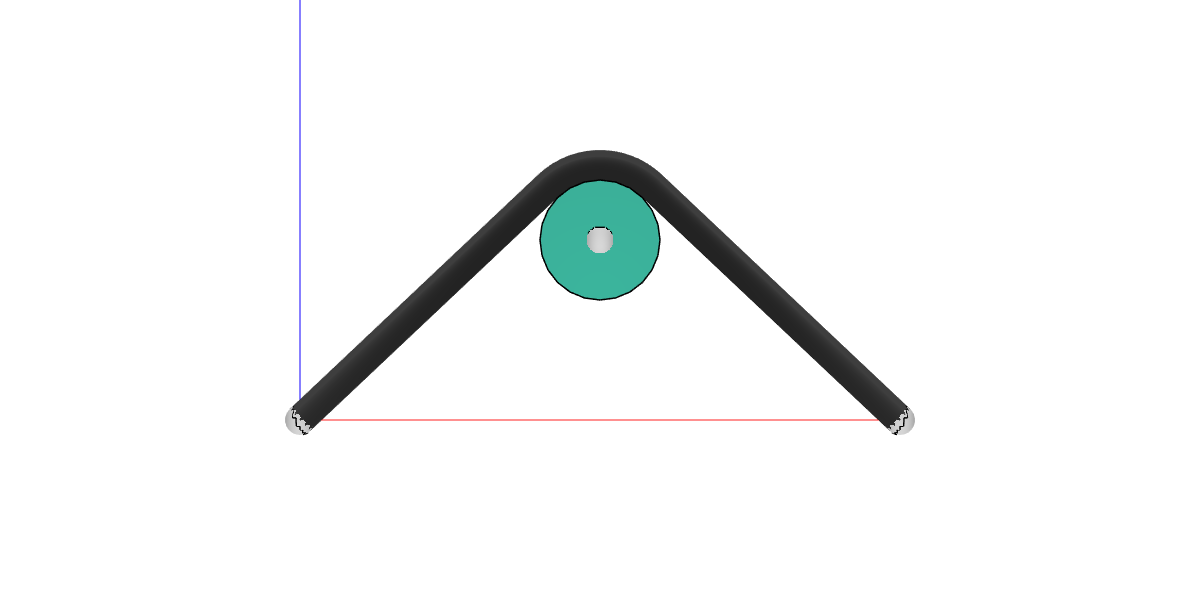

In [2]:
s = Scene()

# Two endpoints to connect the cable to
s.new_point('point A', position=(0,0,0))
s.new_point('point B', position=(10,0,0))

# A point in the middle with a circle
s.new_point('midPoint', position=(5,0,3))
s.new_circle('circle', 
             parent = 'midPoint',  # connect to midpoint, this determines the position
             axis = (0,1,0),       # circle axis into the screen
             radius = 1)  # 

# the new_cable command use endA, endB and 'sheaves' instead of 'connections'
s.new_cable('cable',
            endA = 'point A',
            endB = 'point B',
            sheaves = 'circle',
            diameter = 0.5)

show(s, camera_pos = (5,-2,2), lookat = 'y', scale=5 , width = 1200, height = 600)

## Direction

The direction in which the cable runs over the circle is determined by the direction of the cable and the direction of the axis of the circle.

In this case the cable runs from point A (on the left) towards point B (on the right). The axis of the circle is (0,1,0) meaning it poins into the screen. Using the right-hand-rule determines the direction in which the cable runs over the circle.

If we reverse the direction of the cable such that is runs from right to left then we get the following:

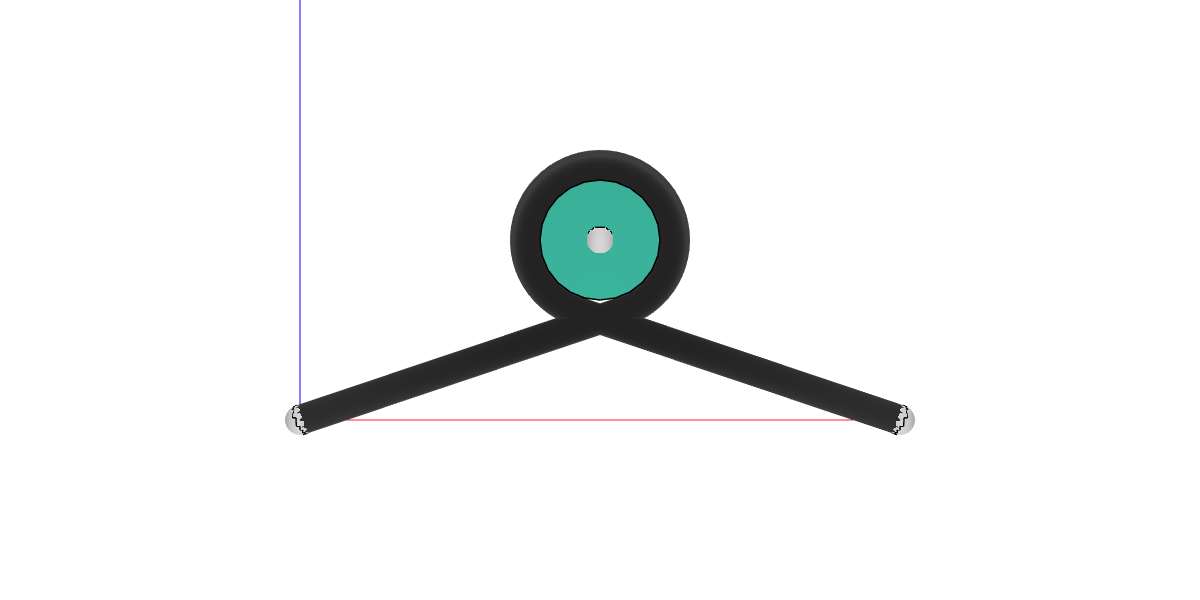

In [3]:
s['cable'].connections = ('point B','circle','point A')
show(s, camera_pos = (5,-2,2), lookat = 'y', scale=5 , width = 1200, height = 600)

### Reversing the direction

Reversing the direction in which a cable runs over a circle is sometimes needed. For example when the same cable contacts the same circle multiple times (grommets!). In those situations the `reversed` property of the `Cable` can be used. This is a boolean specifying that the cable should run over the circle in opposite direction:

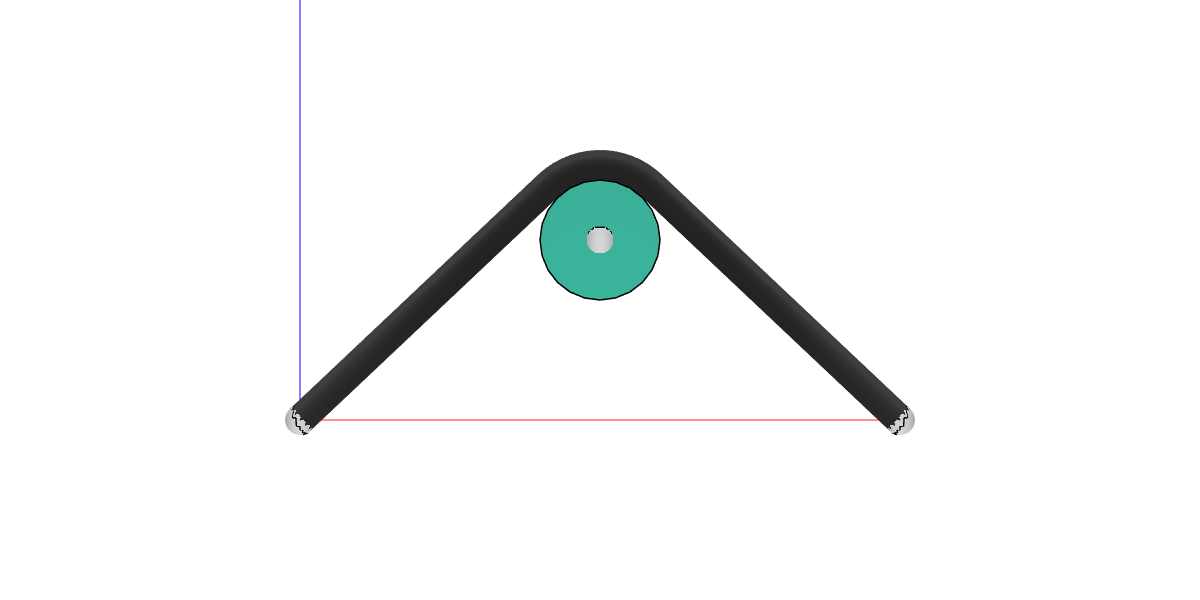

In [4]:
s['cable'].connections = ('point B','circle','point A')  # Keep the cable from right to left

# reverse the connection over the middle connection
s['cable'].reversed = (False, True, False)               
show(s, camera_pos = (5,-2,2), lookat = 'y', scale=5 , width = 1200, height = 600)

The reversed property has to be specified for all connections at the same time. The following is not possible:

In [5]:
try:
    s['cable'].reversed[1] = False
except Exception as E:
    print(E)


'tuple' object does not support item assignment


A work-around to do this would be:

In [6]:
temp = list(s['cable'].reversed)
temp[1] = True
s['cable'].reversed = temp

the same hold for `connections`.

## Cable running over a point / circle with zero diameter

There is a subtle difference between a point and a circle with a diameter of zero:

- If a cable runs over a `Point`, then its centerline runs through that point.
- If a cable runs over a `Circle`, then its skin runs over the circumference of the circle.

Consider the following example:

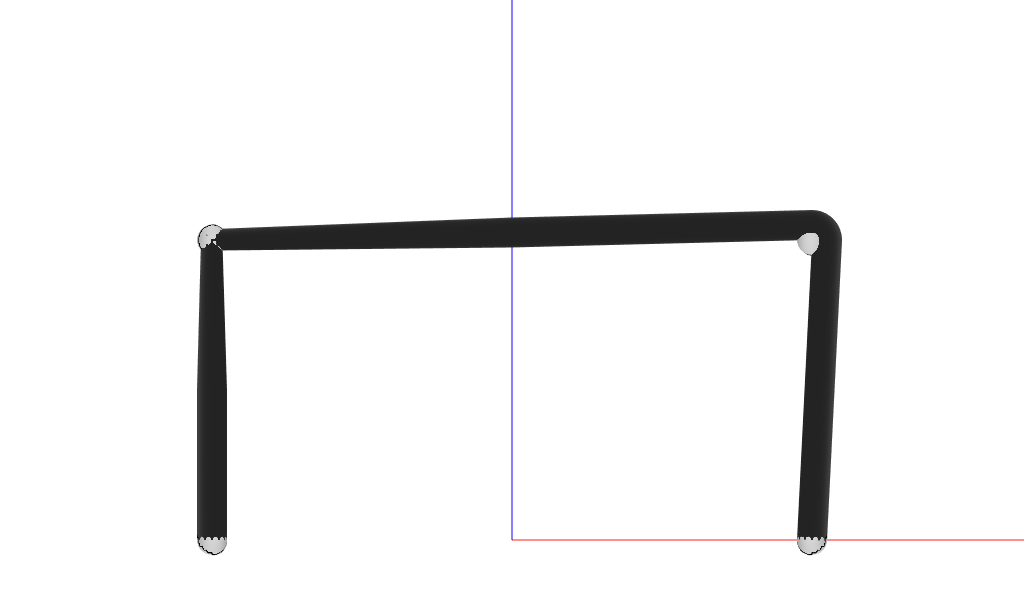

In [7]:
s = Scene()
left = s.new_point('left',position = (-5,0,5))
right = s.new_point('right', position = (5,0,5))

bottom_left = s.new_point('BL', position = (-5,0,0))
bottom_right = s.new_point('BR', position = (5,0,0))

circle_with_zero_diamter = s.new_circle('circle',parent=right, axis=(0,1,0), radius = 0)

s.new_cable('cable',endA = bottom_left, endB= bottom_right, sheaves = [left, circle_with_zero_diamter], diameter = 0.5)
show(s,lookat='y', camera_pos = (0,-10,4), scale=5)


 *<p style="text-align: center;">Left: cable running over a `Point`, right: cable running over a zero-diameter `Circle`</p>*

## Making loops (grommets)

A loop (grommet) can be made by giving a cable the same `Circle` as start and end.

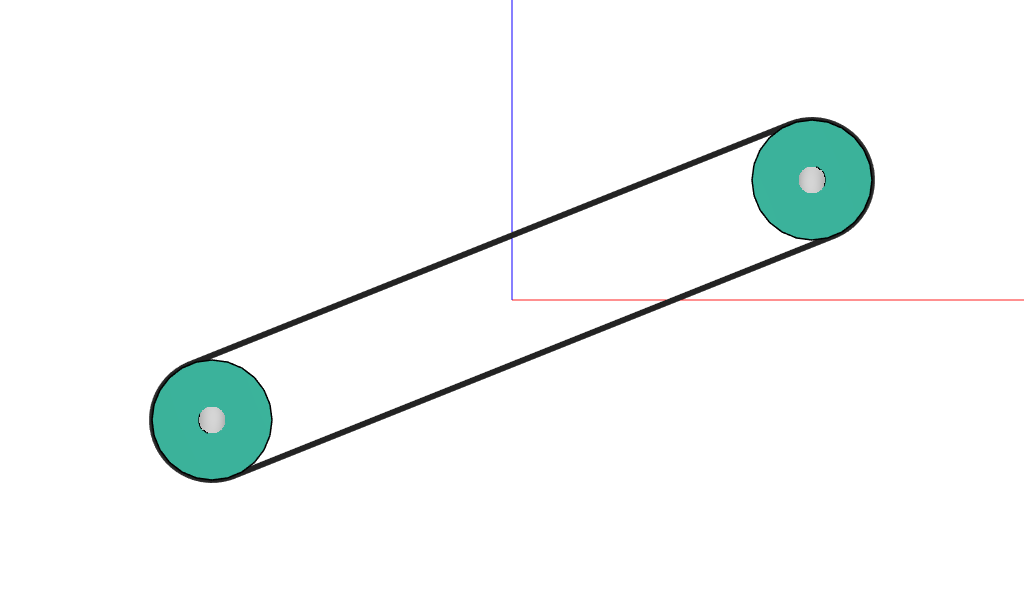

In [8]:
s = Scene()
s.new_point('Point1', position = (-5,0,-2))
s.new_circle('Circle1', parent = 'Point1', axis = (0,1,0), radius = 1)

s.new_point('Point2', position = (5,0,2))
s.new_circle('Circle2', parent = 'Point2', axis = (0,1,0), radius = 1)

s.new_cable("grommet", endA="Circle1", endB = "Circle1", sheaves = ["Circle2"], EA = 100)

show(s,lookat='y', camera_pos = (0,-10,0), scale=5)

See also:  {doc}`Grommet and loop length calculation example<Grommets_loops>`

## 3D effects and sideloads

DAVE is 3D. This means it has to account for the circle not being in-line with the cable.
Consider:

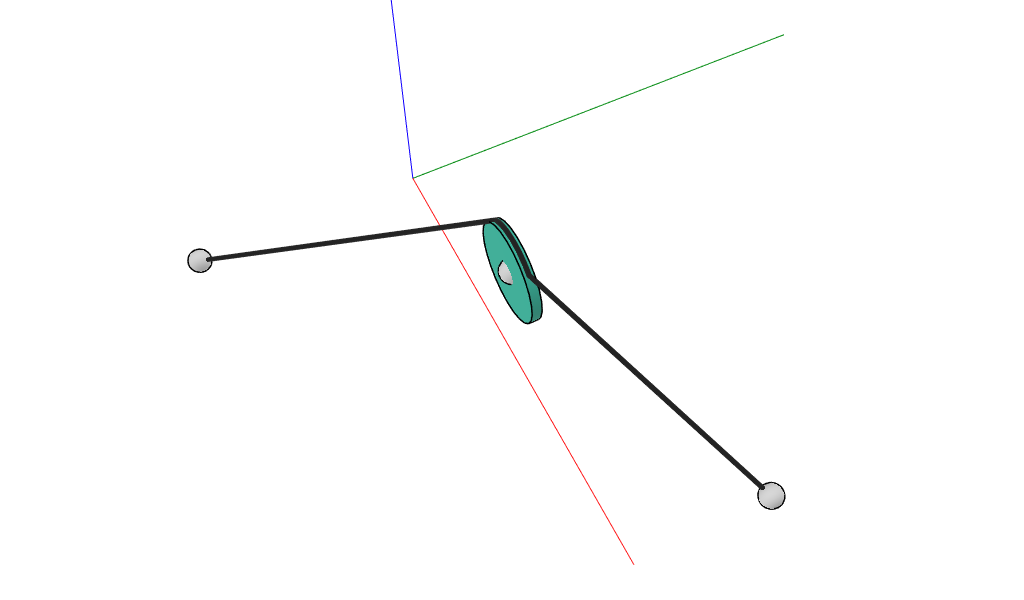

In [11]:
s = Scene()

# Two endpoints to connect the cable to
s.new_point('point A', position=(0,0,0))
s.new_point('point B', position=(10,0,0))

# A point in the middle with a circle
s.new_point('midPoint', position=(5,0,3))
s.new_circle('circle', 
             parent = 'midPoint',  # connect to midpoint, this determines the position
             axis = (0,1,0),       # circle axis into the screen
             radius = 1)  # 

# the new_cable command use endA, endB and 'sheaves' instead of 'connections'
s.new_cable('cable',
            endA = 'point A',
            endB = 'point B',
            sheaves = 'circle',
            diameter = 0.5)

s['point A'].y = -5
s['point B'].y = 3
s['cable'].diameter = 0.01

show(s, lookat = (5,0,2), camera_pos = (15,-5,20))

The general model for determining where the cable leaves the circle is based on the assumption that the cable remains on the circle as long as there is a contact force. This is equivalent to assuming that the circle is a sheave with rims that restrain the cable from running off the sheave sideways.

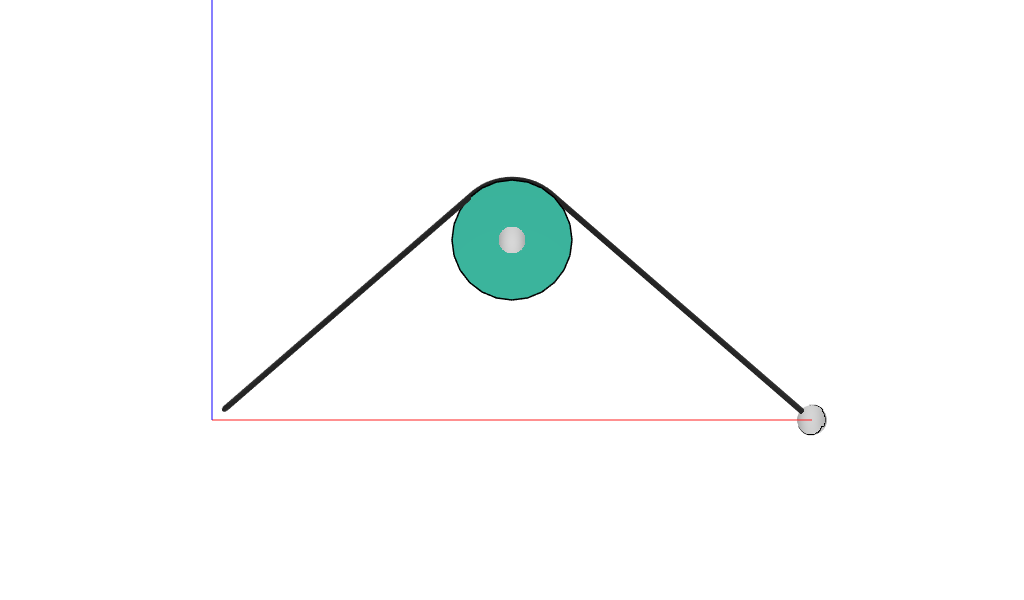

In [12]:
show(s, lookat = 'y', camera_pos = (5,-5,2), scale=5)

This (sheave) model is used till the sidelead becomes more than 45 degrees (which is not realistic to start with). When the sidelead exceeds 45 degrees the contact point is slowly moved towards the point "halfway" the circle. Note that for the situation where the point is on the axis of the circle the point where the cable leaves the circumference of the circle is undefined (yellow).

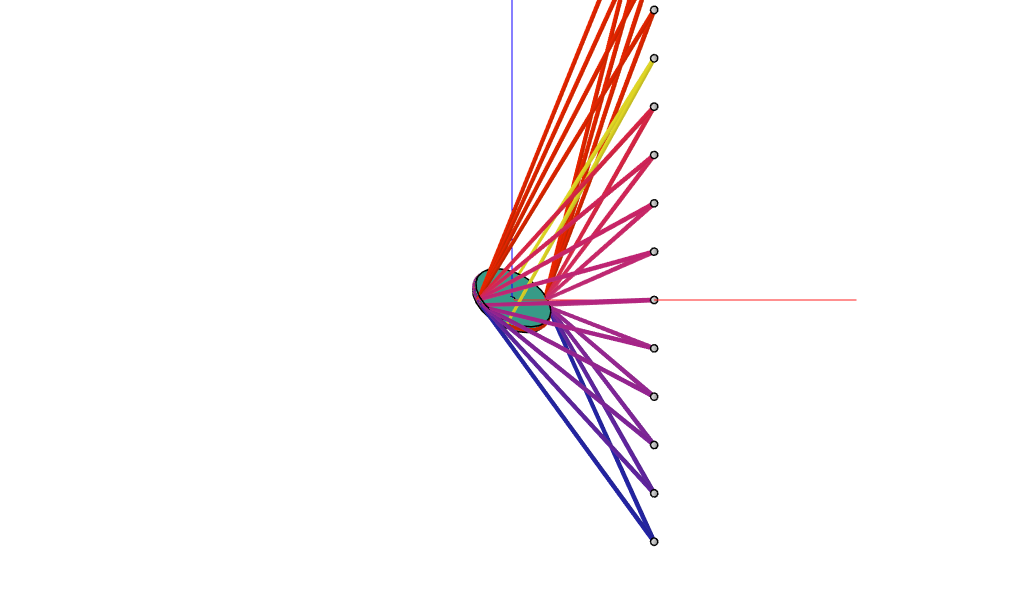

In [13]:
s = Scene()
s.new_point('origin')
c = s.new_circle('circle',parent='origin', axis = (1,0,1), radius=1)

for lz in range(15):
    p = s.new_point(f'point{lz}', position = (5,0,lz-5))
    cab = s.new_cable(f'cable{lz}', endA = p, endB= p, sheaves=[c])
    
    if lz==10:
        cab.color = (254,215,0)
    else:
        cab.color = (25*lz, 0,100-10*lz)

show(s, camera_pos = (22,-16,0), lookat = (0,0,0), geometry_scale=0.3)

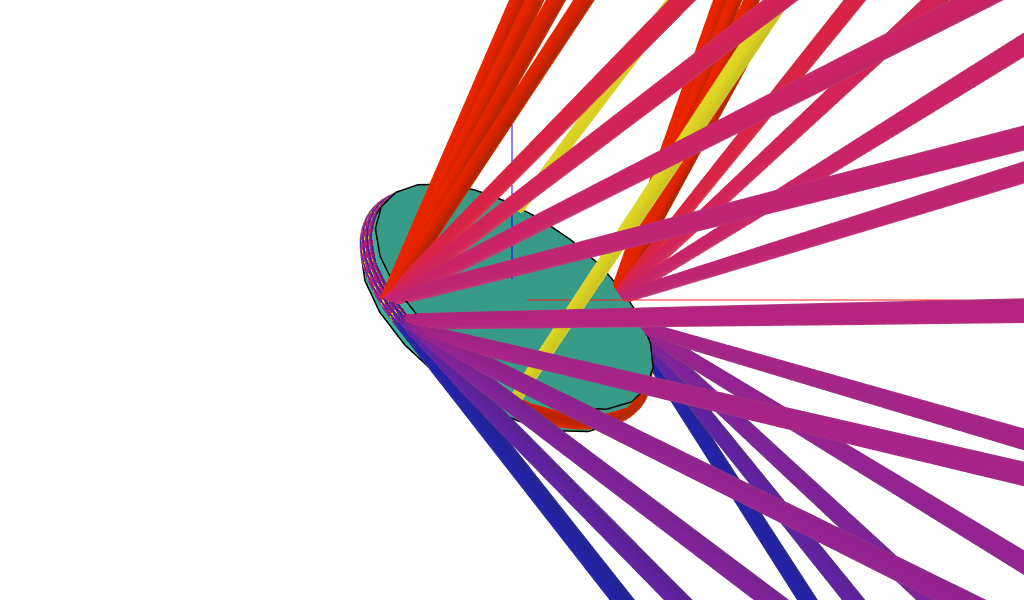

In [14]:
show(s, camera_pos = (5,-5,0), lookat = (0,0,0), geometry_scale=0.3)

### Getting the value of the side-load

The loads on the circle can be obtained from the point that is it connected to.

Property,Value,Unit,Remarks,Explained
applied_force,"(277.613, 0.000, 140.209 )","[kN,kN,kN]",parent axis,Applied force
applied_force_and_moment_global,"(277.613, 0.000, 140.209, 0.000, -14.021, 0.000 )","[kN, kN, kN, kNm, kNm, kNm]",Global axis,Applied force and moment on this point
force,311.011,[kN],,total force magnitude as applied on the point


Property,Value,Unit,Remarks,Explained
axis,"(0.000, 0.000, 1.000 )","[m,m,m]",parent axis system,Direction of the sheave axis
global_axis,"(0.000, 0.000, 1.000 )","[m,m,m]",,Global axis direction


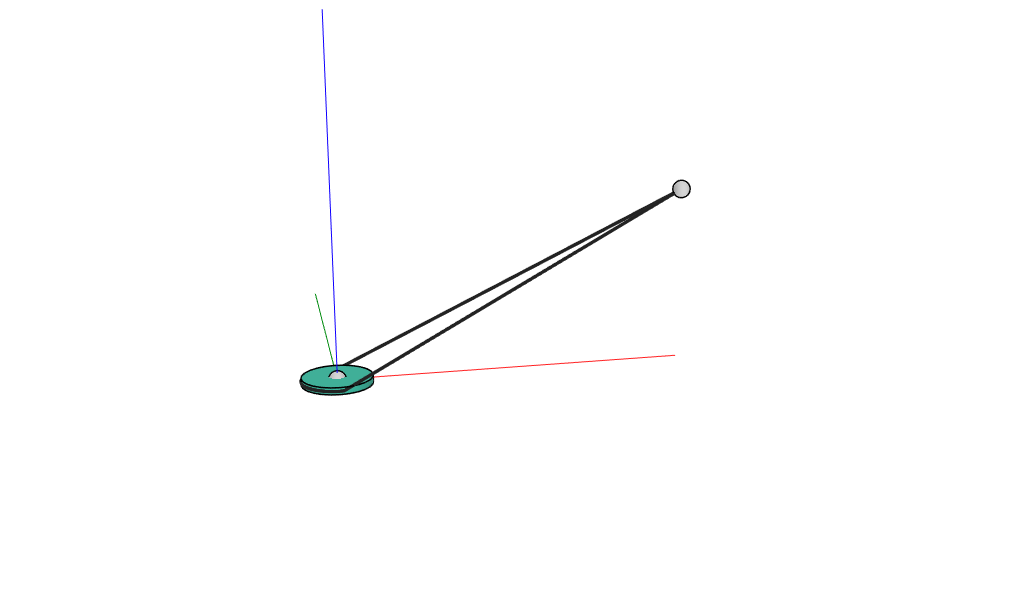

In [15]:
s = Scene()
s.new_point('point0')
c = s.new_circle('circle',parent='point0', axis = (0,0,2), radius=1)
p = s.new_point('point', position = (10,0,5))
cab = s.new_cable(f'cable', endA = p, endB= p, sheaves=[c], length = 10, EA = 100)

s.solve_statics()
    
report(s['point0'],'*force*')
report(c,'*axis*')
show(s, camera_pos = (-2, -30, 10), lookat = (5,0,2))

In general the magnitude of the sideload can be calcualted from the dot-product of the applied load and the direction of the axis. The `axis` property of a circle is normalized by default:

In [ ]:
import numpy as np
sideload = np.dot(s['circle'].axis, s['point0'].applied_force)

print(f'Sideload on the sheave is {sideload:.2f} kN')

Which, in this case, is equal to the z-component of the force applied on the point.

If an angle is needed then this can be calculated from the inverse sinus:

In [ ]:
angle = np.arcsin(sideload/s['point0'].force)

print(f"That's an angle of {np.degrees(angle):.3f} degrees")

Note that the above only works if the circle is the only node that applies force on the point.